In [36]:
import os

import numpy as np
import pickle

from scipy.stats import pearsonr, spearmanr

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from utils import STIM_INFO_PATH, COCO_IMAGES_DIR, STIMULI_IDS_PATH, HEMIS, export_to_gifti
from analyses.ridge_regression_decoding import Standardize, get_distance_matrix, \
    dist_mat_to_pairwise_acc, get_fmri_data_paths, get_nn_latent_data

from feature_extraction.feat_extraction_utils import CoCoDataset
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange
from preprocessing.create_gray_matter_masks import get_graymatter_mask_path
import nibabel
from PIL import Image


# Nearest Neighbors of test images

In [8]:
from utils import FMRI_DATA_DIR

SUBJECT = 'sub-01'
MODEL = "imagebind"
STIM_TYPE = 'image'
BETAS_DIR = os.path.join(FMRI_DATA_DIR, 'betas_new')
train_paths, stim_ids, stim_types = get_fmri_data_paths(BETAS_DIR, SUBJECT, "train_image")

latents, _ = get_nn_latent_data(MODEL, 'avg',
                                'vision_features_cls',
                                'lang_features_cls',
                                stim_ids,
                                stim_types,
                                SUBJECT,
                                "train"
                                )

train_paths = np.array(train_paths)[stim_types == STIM_TYPE]

/home/mitja/multimodal_decoding/analyses/ridge_regression_decoding.py:187: RuntimeWarning: Mean of empty slice.
  'mean': nn_latent_vectors[stim_types == CAPTION].mean(axis=0),
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [3]:
gray_matter_mask_path = get_graymatter_mask_path(SUBJECT)
gray_matter_mask_img = nibabel.load(gray_matter_mask_path)
gray_matter_mask_data = gray_matter_mask_img.get_fdata()
gray_matter_mask = gray_matter_mask_data == 1
print(f"Gray matter mask size: {gray_matter_mask.sum()}")

train_fmri_betas = []
for idx in trange(len(train_paths), desc="loading fmri data"):
    sample = nibabel.load(train_paths[idx])
    sample = sample.get_fdata()
    sample = sample[gray_matter_mask].astype('float32').reshape(-1)
    train_fmri_betas.append(sample)

train_fmri_betas = np.array(train_fmri_betas)


Gray matter mask size: 162649


loading fmri data: 100%|██████████| 4897/4897 [00:24<00:00, 199.31it/s]


In [4]:
test_paths, test_stim_ids, test_stim_types = get_fmri_data_paths(BETAS_DIR, SUBJECT, "test")
test_paths = np.array(test_paths)[test_stim_types == STIM_TYPE]
test_stim_ids = test_stim_ids[test_stim_types == STIM_TYPE]
test_paths.shape

(70,)

In [5]:
test_fmri_betas = []
for idx in trange(len(test_paths), desc="loading fmri data"):
    sample = nibabel.load(test_paths[idx])
    sample = sample.get_fdata()
    sample = sample[gray_matter_mask].astype('float32').reshape(-1)
    test_fmri_betas.append(sample)

test_fmri_betas = np.array(test_fmri_betas)


loading fmri data: 100%|██████████| 70/70 [00:00<00:00, 129.88it/s]


In [6]:
nan_locations = np.isnan(train_fmri_betas[0])
train_fmri_betas = train_fmri_betas[:, ~nan_locations]
test_fmri_betas = test_fmri_betas[:, ~nan_locations]
print(np.sum(np.isnan(train_fmri_betas)))
print(np.sum(np.isnan(test_fmri_betas)))

11635
1468


In [8]:
scaler = StandardScaler()
scaler.fit(train_fmri_betas)

train_fmri_betas_standardized = scaler.transform(train_fmri_betas)

# test_scaler = StandardScaler()
# test_scaler.fit(test_fmri_betas)
# test_fmri_betas_transformed = test_fmri_betas - diff_train_test
test_fmri_betas_standardized = scaler.transform(test_fmri_betas)

In [9]:
print(np.nanmean(train_fmri_betas.mean(axis=0)))
print(np.nanmean(test_fmri_betas.mean(axis=0)))
print(np.nanmean(test_fmri_betas_standardized.mean(axis=0)))

# print(np.nanmean(test_fmri_betas_transformed.mean(axis=0)))


0.0027427217
0.0077287145
0.004825376


In [17]:
results = dict()
for hemi in HEMIS:
    results[hemi] = pickle.load(open(f'/home/mitja/data/multimodal_decoding/whole_brain_encoding/train/sub-01/imagebind_avg_test_avg_vision_features_cls_lang_features_cls_surface_fsaverage7_{hemi}_hemi/results.p', 'rb'))

test_stim_types = results[HEMIS[0]]['stimulus_types']
test_stim_ids = results[HEMIS[0]]['stimulus_ids']
test_predicted_betas = {hemi: results[hemi]['test_predicted_betas'] for hemi in HEMIS}
test_predicted_betas_imgs = {hemi: betas[test_stim_types == 'image'] for hemi, betas in test_predicted_betas.items()}
test_predicted_betas_caps = {hemi: betas[test_stim_types == 'caption'] for hemi, betas in test_predicted_betas.items()}

test_betas = {hemi: results[hemi]['test_betas'] for hemi in HEMIS}
test_betas_imgs = {hemi: betas[test_stim_types == 'image'] for hemi, betas in test_betas.items()}
test_betas_caps = {hemi: betas[test_stim_types == 'caption'] for hemi, betas in test_betas.items()}

nan_locations = {hemi: results[hemi]['nan_locations'] for hemi in HEMIS}


# test_stim_ids = test_stim_ids[test_stim_types == STIM_TYPE]

print(test_predicted_betas['left'].shape)
# print(test_stim_ids)


(140, 149107)


left


100%|██████████| 149107/149107 [04:16<00:00, 581.47it/s]


right


100%|██████████| 147738/147738 [04:15<00:00, 577.20it/s]


(array([  4.,  23.,  73., 118.,  70.,  21.,   1.,   0.,   0., 690.]),
 array([-0.15607063, -0.0404888 ,  0.07509304,  0.19067487,  0.30625671,
         0.42183854,  0.53742037,  0.65300221,  0.76858404,  0.88416588,
         0.99974771]),
 <BarContainer object of 10 artists>)

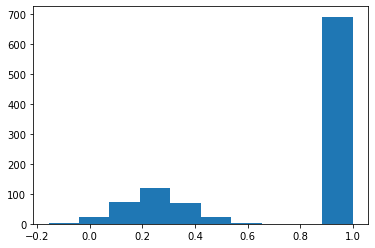

In [10]:
corrs_test_betas = dict()
corrs_test_errors = dict()
for hemi in HEMIS:
    corrs_test_betas[hemi] = []
    corrs_test_errors[hemi] = []
    print(hemi)
    for vertex in trange(test_predicted_betas_imgs[hemi].shape[1]):
        preds_imgs = test_predicted_betas_imgs[hemi][:, vertex]
        preds_caps = test_predicted_betas_caps[hemi][:, vertex]
        # print(preds_imgs[:10])
        # print(preds_caps[:10])
        # print(preds_imgs[0])
        # print(preds_caps[0])
        assert np.all(preds_imgs == preds_caps)

        error_imgs = preds_imgs - test_betas_imgs[hemi][:, vertex]
        error_caps = preds_caps - test_betas_caps[hemi][:, vertex]
        # print(error_imgs[:10])
        # print(error_caps[:10])
        # print(pearsonr(error_imgs, error_caps)[0])
        corrs_test_errors[hemi].append(pearsonr(error_imgs, error_caps)[0])

        corrs_test_betas[hemi].append(pearsonr(test_betas_imgs[hemi][:, vertex], test_betas_caps[hemi][:, vertex])[0])
        # corrs[hemi].append(pearsonr(preds_imgs, test_betas_imgs[hemi][:, vertex])[0])

# print(corrs['left'])
plt.hist(corrs_test_betas['left'])


In [40]:
for hemi in HEMIS:
    corrs = np.repeat(np.nan, nan_locations[hemi].shape)
    corrs[~nan_locations[hemi]] = corrs_test_betas[hemi]
    export_to_gifti(corrs, f'corrs_test_betas_{hemi}.gii')

for hemi in HEMIS:
    corrs = np.repeat(np.nan, nan_locations[hemi].shape)
    corrs[~nan_locations[hemi]] = corrs_test_errors[hemi]
    export_to_gifti(corrs, f'corrs_test_errors_{hemi}.gii')


left


 11%|█         | 11/100 [00:00<00:00, 109.37it/s]

[ 0.00446275  0.00592992  0.00937447  0.00178891  0.00622071  0.00853676
  0.00297266  0.00679754  0.00242287  0.01137282  0.00627919  0.00631171
  0.00646283  0.00605193  0.01037216  0.00517885  0.00901688  0.00972476
  0.00234042  0.0079516   0.00755643  0.01247737  0.00435472  0.009357
  0.00449708  0.0047751   0.00788438  0.00923255  0.0095444   0.00262438
  0.00583461  0.00736765  0.00962734  0.01259181  0.00145056  0.00980001
  0.00313603  0.01082795  0.00650736  0.00947971  0.00578604  0.01105697
  0.00886671  0.01056086  0.00515839  0.00901522  0.0086035   0.0079901
  0.00413848  0.00680954  0.00644344  0.00419186  0.00479755  0.0020399
  0.00582327  0.00567986  0.00346387  0.00493475  0.00053332  0.0038403
  0.0112628   0.00446241  0.00837842  0.00435705  0.00639323  0.00440492
  0.00247752  0.00379852  0.00659222 -0.0005087 ]
[ 0.00330894  0.00439977  0.00508952  0.00975846  0.00740936  0.0037138
  0.00499887  0.00473769  0.0004511   0.01003588  0.00184649  0.00394856
  0.008

 22%|██▏       | 22/100 [00:00<00:00, 108.26it/s]

SignificanceResult(statistic=0.27183973405651296, pvalue=0.022817589211952854)
[-0.01955167 -0.01765559 -0.01474814 -0.01758113 -0.01865996 -0.01709116
 -0.01761995 -0.01589036 -0.02010378 -0.01615566 -0.01525169 -0.01926372
 -0.01816813 -0.01864103 -0.02074963 -0.01597487 -0.01886017 -0.01729545
 -0.01675975 -0.01985044 -0.01623439 -0.01785065 -0.01901815 -0.02071622
 -0.0163809  -0.02082627 -0.01598273 -0.01746887 -0.02005043 -0.01779944
 -0.02435273 -0.01683851 -0.01518055 -0.02013552 -0.01846574 -0.01865095
 -0.01795248 -0.0167305  -0.01830029 -0.01759674 -0.017308   -0.01792742
 -0.01827172 -0.0189059  -0.02089195 -0.01701323 -0.01786519 -0.0204808
 -0.01934356 -0.01733552 -0.01518172 -0.01914444 -0.0172253  -0.02013226
 -0.01738086 -0.02077576 -0.01760472 -0.01740071 -0.01621145 -0.01868327
 -0.01885771 -0.01677659 -0.02264128 -0.0191638  -0.01786438 -0.02226507
 -0.01699983 -0.0236901  -0.01934098 -0.01770951]
[-0.0180201  -0.01652418 -0.01846868 -0.01844928 -0.01690019 -0.01857

 33%|███▎      | 33/100 [00:00<00:00, 107.29it/s]

SignificanceResult(statistic=0.2238999212667308, pvalue=0.062422452445175386)
[-0.0324519  -0.00191889 -0.01828848 -0.01985564  0.00387319 -0.01945036
 -0.03796919 -0.0317145  -0.02045781 -0.01131663 -0.02573589 -0.00861114
 -0.00899615 -0.01307695 -0.03268778  0.00308963 -0.00786201 -0.00461661
 -0.01989696 -0.03629779  0.00872557 -0.01238537 -0.02663226 -0.01413197
 -0.01642061 -0.02231857 -0.03556288 -0.01457357 -0.00423626 -0.01673481
 -0.01235849 -0.00781126 -0.00556897 -0.02194584 -0.02034501  0.00266672
 -0.01541662 -0.00881544 -0.03080739 -0.02526369 -0.01583072  0.01061235
 -0.01862616  0.0022125  -0.0270339  -0.00386968 -0.00532346 -0.01118847
 -0.00714555 -0.02915373 -0.00702369 -0.03890457 -0.00671602 -0.02222138
  0.0010615  -0.03443635 -0.03247543 -0.02407405  0.01072511 -0.03087311
 -0.0156753  -0.02185613 -0.02475828 -0.02578647 -0.01543134 -0.00856719
 -0.00808825 -0.02355055 -0.0083705  -0.01371731]
[-0.02821533 -0.00122029 -0.02229493 -0.01584237  0.00514581 -0.01645

 46%|████▌     | 46/100 [00:00<00:00, 113.67it/s]

SignificanceResult(statistic=0.9556644213104714, pvalue=7.884693910777594e-38)
[-0.0232321  -0.01069361 -0.00511232 -0.00823701  0.00401395 -0.00369416
 -0.01727351 -0.01268275 -0.01034072 -0.01715677 -0.01866199 -0.00457824
  0.00374689 -0.00299172 -0.02127082  0.00032607 -0.01648021 -0.0098126
 -0.00990737 -0.02657927 -0.00495173 -0.0139597  -0.01077495  0.00558679
 -0.01995481 -0.01362682 -0.01466738 -0.01456328  0.00333973 -0.01152031
 -0.00589241 -0.00913503  0.01204469 -0.02498839 -0.01771031 -0.00835214
 -0.00938758 -0.02173921 -0.01044938 -0.01545207 -0.01537081  0.01280257
 -0.00388075  0.01009019 -0.01299186 -0.00463575 -0.00477555 -0.00393583
 -0.0045718  -0.02213121 -0.0162505  -0.01678321  0.00230349 -0.0252164
 -0.0062604  -0.02275059 -0.022567   -0.01186084 -0.01337801 -0.0089041
 -0.01389911 -0.01429912 -0.03251327 -0.01442336 -0.00809861 -0.01187381
  0.00804339 -0.02371356 -0.01413797 -0.02458696]

 58%|█████▊    | 58/100 [00:00<00:00, 110.88it/s]


[-0.0225615  -0.01174168 -0.00912125 -0.00684806  0.00120852 -0.00148873
 -0.01880537 -0.0136877  -0.01256369 -0.01425071 -0.02020307 -0.00456577
  0.00312319 -0.00411217 -0.02259077 -0.0002293  -0.01768549 -0.0101511
 -0.01327116 -0.02648692 -0.00592994 -0.01460029 -0.01179585  0.00405395
 -0.02088813 -0.01060896 -0.01450169 -0.00957717  0.00333189 -0.00876593
 -0.00308876 -0.00905704  0.0086189  -0.02280047 -0.01553967 -0.00926416
 -0.00876572 -0.0208819  -0.00840432 -0.01725859 -0.01158113  0.01382035
 -0.0043362   0.00506763 -0.01453366 -0.00287023 -0.00643738 -0.00799593
 -0.00599804 -0.02144246 -0.01650279 -0.01541521  0.0046913  -0.02597541
 -0.00353229 -0.02521095 -0.02484802 -0.01430074 -0.01572234 -0.01112113
 -0.01582955 -0.01512379 -0.03088741 -0.01422927 -0.01192218 -0.01341917
  0.00701249 -0.02306282 -0.01293987 -0.02497929]
[-0.01454179 -0.00551106  0.00194543 -0.00115399  0.01064712  0.00509119
 -0.01226907 -0.00637017 -0.00663189 -0.01049576 -0.01411307  0.00210732
 

 83%|████████▎ | 83/100 [00:00<00:00, 113.20it/s]


[-0.00339369 -0.01903716 -0.03042082 -0.00201658 -0.03639659  0.0027915
 -0.00270383 -0.01800072 -0.01505802 -0.00268816 -0.00986149 -0.00555972
 -0.01255965 -0.0141939  -0.00859032 -0.02703444 -0.01746931 -0.00480433
 -0.03047583  0.00722763 -0.01242975 -0.008195   -0.00405696 -0.01076036
 -0.01137953  0.00102413 -0.01501888 -0.01052289 -0.0033303  -0.01847149
 -0.02461136 -0.00225408 -0.01874663  0.00379914 -0.01549442 -0.00967404
 -0.02670391 -0.01044193 -0.02480583 -0.01933374 -0.01426406 -0.02719201
  0.01675948 -0.01638445 -0.00339095 -0.00745903 -0.00693835 -0.03550508
 -0.01594266  0.00035007 -0.01876849 -0.01367286 -0.01482947 -0.00789072
  0.00894036  0.0020578  -0.01257742 -0.00599596 -0.02291511 -0.01006171
 -0.01914492 -0.01534812 -0.00650274 -0.00551866 -0.01364271 -0.00903461
 -0.01243323  0.01132756 -0.00949358 -0.01261073]
[ 1.08794076e-02 -6.35684887e-03 -1.24882981e-02  1.13899997e-02
 -2.29824837e-02  1.47578642e-02  1.11410115e-02 -1.64642674e-03
 -1.35577272e-03 

100%|██████████| 100/100 [00:00<00:00, 114.02it/s]



[0.01177559 0.01169634 0.00982464 0.00947915 0.01076433 0.01148025
 0.01229478 0.0074165  0.00892769 0.01413017 0.0108932  0.01142715
 0.01528765 0.00816386 0.0081151  0.01040858 0.01432601 0.00885284
 0.00806964 0.00941089 0.01022315 0.00971232 0.00989847 0.01348094
 0.0054822  0.00607915 0.00934898 0.00786588 0.01056465 0.00866909
 0.00848405 0.01003105 0.01157269 0.00925922 0.00513178 0.00817744
 0.01020702 0.01001111 0.01153871 0.00743094 0.00889809 0.00988861
 0.01101697 0.01094695 0.01038516 0.00693944 0.01020449 0.01091787
 0.01150061 0.01042746 0.01133113 0.00920146 0.01243021 0.00870677
 0.01093244 0.00734719 0.00887998 0.00992193 0.00967499 0.00911608
 0.00983539 0.0128489  0.01254322 0.0105583  0.01034403 0.01155328
 0.01455937 0.01067643 0.01049141 0.0105612 ]
[ 1.48417032e-03  1.59095053e-03 -5.67322015e-04  5.03744697e-04
 -6.62916573e-04 -1.07445107e-04  1.01562985e-03 -2.90239789e-03
  6.26605979e-05  1.27222715e-03 -1.03245198e-03  9.93677881e-04
  1.56693242e-03 -1.3

 12%|█▏        | 12/100 [00:00<00:00, 110.32it/s]

[0.01187165 0.01042135 0.00872562 0.01297929 0.0099927  0.00796086
 0.01138889 0.01163439 0.01275114 0.0099905  0.01119327 0.01051317
 0.01061389 0.00433806 0.01330673 0.01120731 0.00934077 0.01317979
 0.00758297 0.01529308 0.01121866 0.00953986 0.01145077 0.00613701
 0.01062868 0.01338573 0.01321067 0.00559569 0.00736581 0.00949342
 0.00856204 0.00897344 0.0105075  0.00776799 0.01101111 0.00961762
 0.00745739 0.01112573 0.00791623 0.01322143 0.00936186 0.01200964
 0.01090605 0.00674651 0.00481334 0.01095798 0.0068739  0.01274506
 0.00640976 0.01194173 0.01442834 0.01246446 0.00795791 0.00858981
 0.00970279 0.01311191 0.00955058 0.00729334 0.00849592 0.00859118
 0.00509052 0.0074492  0.00822054 0.01174892 0.01113617 0.01358777
 0.01508735 0.00921713 0.0085144  0.01304336]
[0.00680864 0.00721978 0.00554911 0.01094571 0.00929861 0.00862338
 0.00569614 0.00949075 0.01058978 0.00597175 0.00783637 0.00984707
 0.00745086 0.00752618 0.0090466  0.00919135 0.00738557 0.00568092
 0.00571456 0.01

 35%|███▌      | 35/100 [00:00<00:00, 107.60it/s]

SignificanceResult(statistic=0.9733706587350188, pvalue=3.1247576734729234e-45)
[0.02670195 0.02830372 0.02764752 0.0247603  0.02605191 0.02957542
 0.03014681 0.02401083 0.02201815 0.02713887 0.02858562 0.02592797
 0.02736685 0.02690576 0.03078618 0.03006073 0.02674635 0.02487209
 0.0288871  0.02956523 0.02950307 0.02985509 0.02994194 0.02937828
 0.02638607 0.02513539 0.02543819 0.02801112 0.02748469 0.02244588
 0.02772076 0.02795675 0.02527312 0.02846971 0.02690752 0.03007108
 0.02705873 0.02837785 0.0274612  0.02579741 0.02837924 0.02789855
 0.02878611 0.02973506 0.0243158  0.02525248 0.02745745 0.02810018
 0.03123622 0.02473499 0.02573231 0.02560446 0.02615538 0.02941749
 0.02542709 0.0232393  0.03076493 0.03300142 0.02722968 0.02913685
 0.02204934 0.02795058 0.02650776 0.02576179 0.02760508 0.02887156
 0.02800342 0.02727367 0.02545863 0.02795315]
[0.02900742 0.03071939 0.02913396 0.02669204 0.03080374 0.02486106
 0.02879755 0.02884114 0.02618336 0.02686925 0.02236654 0.02798857
 0.

 57%|█████▋    | 57/100 [00:00<00:00, 106.80it/s]

SignificanceResult(statistic=0.940267693115213, pvalue=1.5432624310586735e-33)
[-0.01220242  0.01426716 -0.01123309  0.0118239  -0.00494797 -0.00378176
 -0.01322397 -0.02235805 -0.02037857  0.00541893 -0.00399931  0.01656454
  0.00117948 -0.00684028 -0.00943703 -0.00097177 -0.00049983 -0.00110757
 -0.01340566 -0.01194937  0.00344293  0.01058459 -0.02900522  0.00069167
 -0.00890477 -0.00054878 -0.00614573 -0.00433012 -0.00751798 -0.00751367
 -0.02368648  0.00752661  0.00467849 -0.00459026 -0.01677641 -0.00465544
 -0.00569634  0.00243708 -0.01368833 -0.00276236  0.00229729  0.00112818
 -0.0091861   0.00197549 -0.00502967 -0.00803412  0.01491426 -0.00569028
  0.01295337 -0.00433177  0.00076778 -0.01245109  0.00465881 -0.01115085
  0.00402955 -0.01036307 -0.00783191  0.00072047 -0.00149313 -0.01983314
 -0.00702193 -0.00179959 -0.00764555 -0.02042264 -0.00728002 -0.00036585
  0.01222392 -0.00566818  0.00153314  0.00177539]
[-1.06492164e-02  1.12477683e-02 -1.38658734e-02  1.68811591e-02
 -5

 81%|████████  | 81/100 [00:00<00:00, 111.67it/s]

[-0.01126097  0.01188903 -0.01844915 -0.03715705 -0.01606063 -0.01992559
 -0.01642517 -0.03507186 -0.01543798 -0.01489215 -0.03395878 -0.0320739
  0.00391703 -0.00512856 -0.03243579 -0.0126055  -0.01467569 -0.00768489
 -0.02128088 -0.03921329 -0.01056508 -0.02892716 -0.02823266  0.00940924
 -0.02035716 -0.02825179 -0.03730131 -0.00130509 -0.02177629 -0.01654559
 -0.02290975 -0.00787491 -0.01352293 -0.00839017 -0.01518591 -0.0040854
 -0.00660647 -0.01841469 -0.03526316 -0.03662273 -0.00754913 -0.00784756
 -0.02507066 -0.01405107  0.00376176 -0.00539736  0.00151286 -0.00832355
 -0.00116379 -0.02341243 -0.0162915  -0.03996579 -0.00885745 -0.01430984
 -0.00665363 -0.02438957 -0.0149975  -0.01905909 -0.01265093 -0.0344461
 -0.0144186   0.00721838 -0.02088944 -0.04056945 -0.01538479 -0.02800934
 -0.0086082  -0.03233981 -0.00566653 -0.03403995]
[-0.00765025  0.01153936 -0.018696   -0.03674512 -0.01677668 -0.0167745
 -0.01576905 -0.03854885 -0.02089635 -0.0179214  -0.03650004 -0.03312106
  0.0

100%|██████████| 100/100 [00:00<00:00, 108.40it/s]


SignificanceResult(statistic=0.15464963695214765, pvalue=0.20114350230625652)
[ 2.85872643e-03  1.90895816e-02 -4.01088246e-03 -7.14249734e-04
  2.68093809e-03  5.90110435e-03 -1.36634304e-02 -1.17774847e-02
 -6.04494922e-03  1.60822655e-02 -5.99808684e-03  8.48084415e-03
  2.01918048e-02  1.27195374e-02 -7.70630419e-03  5.99720233e-03
  1.54858079e-02  1.29394938e-02  1.38341778e-03 -1.21288240e-03
  2.61491232e-02  1.91889012e-02 -1.17739761e-02  8.38298119e-03
  4.80035206e-03  2.15350663e-03 -7.69903548e-03  6.28261020e-03
 -2.23286979e-03  1.12121013e-04  3.19087965e-03  1.11225846e-02
  9.18547901e-03  4.44375911e-03 -2.01796747e-05  2.33069709e-02
  9.38037849e-03  1.62895374e-02 -2.89596325e-04 -3.48035296e-03
  7.87116588e-03  1.67073907e-02  4.75056222e-03  2.35544860e-02
  3.60025305e-03  1.00443876e-02  1.99728056e-02  2.29116919e-02
  2.99275194e-02  1.86614071e-04  2.56285697e-02 -1.21592233e-02
  1.60688109e-02 -3.26501232e-03  1.63694983e-02  6.03092110e-03
 -3.84986842

(array([ 4.,  4., 10.,  9.,  3.,  3.,  0.,  0.,  0., 67.]),
 array([-0.01758376,  0.08407313,  0.18573003,  0.28738693,  0.38904383,
         0.49070073,  0.59235762,  0.69401452,  0.79567142,  0.89732832,
         0.99898522]),
 <BarContainer object of 10 artists>)

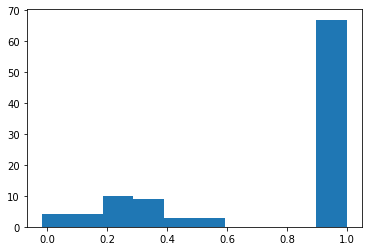

In [45]:
corrs_test_errors_spearman = dict()
for hemi in HEMIS:
    corrs_test_errors_spearman[hemi] = []
    print(hemi)
    for vertex in trange(100): #trange(test_predicted_betas_imgs[hemi].shape[1]):
        preds_imgs = test_predicted_betas_imgs[hemi][:, vertex]
        preds_caps = test_predicted_betas_caps[hemi][:, vertex]

        error_imgs = preds_imgs - test_betas_imgs[hemi][:, vertex]
        error_caps = preds_caps - test_betas_caps[hemi][:, vertex]
        print(error_imgs)
        print(error_caps)
        print(preds_imgs)
        print(test_betas_imgs[hemi][:, vertex])
        
        print(spearmanr(error_imgs, error_caps))
        corrs_test_errors_spearman[hemi].append(spearmanr(error_imgs, error_caps)[0])


# print(corrs['left'])
plt.hist(corrs_test_errors_spearman['left'])


In [ ]:
from sklearn.metrics import r2_score
corrs_test_r2 = dict()
for hemi in HEMIS:
    corrs_test_r2[hemi] = []
    print(hemi)
    for vertex in trange(1000): #trange(test_predicted_betas_imgs[hemi].shape[1]):
        preds_imgs = test_predicted_betas_imgs[hemi][:, vertex]
        preds_caps = test_predicted_betas_caps[hemi][:, vertex]

        assert np.all(preds_imgs == preds_caps)

        r2_imgs = r2_score(preds_imgs, test_betas_imgs[hemi][:, vertex])
        r2_caps = r2_score(preds_imgs, test_betas_caps[hemi][:, vertex])
        print(r2_imgs)
        print(r2_caps)

        corrs_test_r2[hemi].append(np.abs(r2_imgs - r2_caps))


# print(corrs['left'])
plt.hist(corrs_test_r2['left'])
